Notebook utilizzato per la selezione dei parametri da utilizzare nel bdt. Si utilizza una grid search seguita da cross validation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pickle

## Data preliminary

Setting weigths for background, plotting distributions and correlations of features

In [2]:
%run analysis_utils.py


In [3]:
df_ML=pd.read_pickle('df_ML.pkl')

In [4]:
bkg=df_ML.query('y==0')
sig=df_ML.query('y==1')

In [5]:
df_ML.head()

,V0pt,TPCnSigmaHe3,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,PiProngPt,He3ProngPt,ProngsDCA,He3ProngPvDCA,PiProngPvDCA,NpidClustersHe3,TPCnSigmaPi,Lrec,y
0,6.746391,-0.25,5.814942,2.995691,0.867735,0.999946,0.0,0.437348,6.324535,0.06,0.256,0.256,155.0,-0.25,47.646801,1
1,6.835735,1.50,0.966770,2.995311,0.800614,0.999106,0.0,0.693000,6.144546,0.25,0.256,0.256,157.0,0.00,7.554959,1
2,5.300184,-0.50,4.576069,2.991251,0.883767,0.999968,0.0,0.333450,4.986949,0.39,0.256,0.256,158.0,-0.25,25.327280,1
3,8.355766,0.25,1.887362,2.996414,-0.877246,1.000000,0.0,0.538646,7.830958,0.14,0.211,0.256,159.0,0.50,17.692358,1
4,5.021091,0.00,11.131063,2.990786,-0.849284,0.999946,0.0,0.430465,4.593822,0.13,0.256,0.256,159.0,2.00,66.116478,1


In [6]:
data=pd.concat([bkg,sig],ignore_index=True)
data=data.sample(frac=1)

In [9]:
training_columns=['PiProngPvDCA', 'He3ProngPvDCA', 'V0CosPA', 'ProngsDCA', 'DistOverP', 'ArmenterosAlpha','NpidClustersHe3','He3ProngPt']

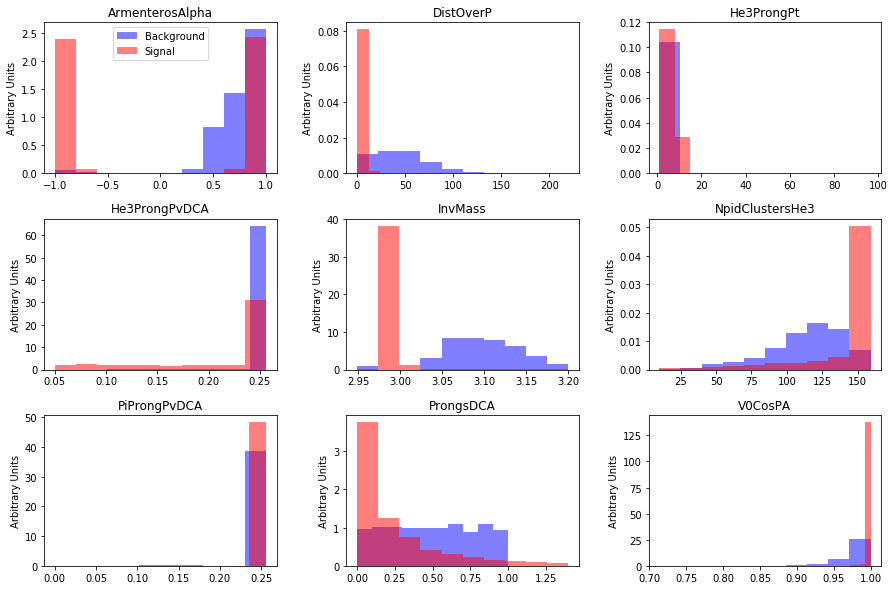

In [10]:
plot_distr(data,training_columns+['InvMass'])

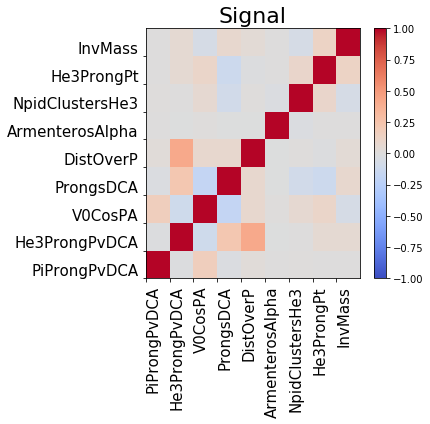

In [11]:
plot_corr(data,training_columns+['InvMass'],"Signal")

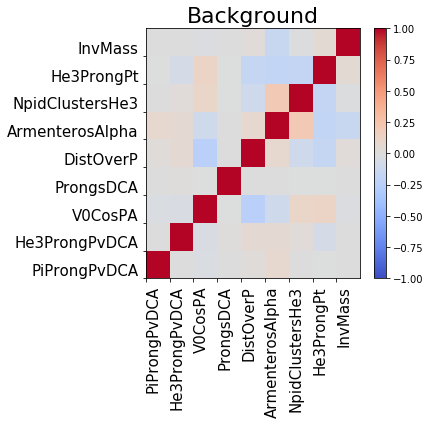

In [12]:
plot_corr(data,training_columns+['InvMass'],"Background")

In [13]:
y_target=data["y"]

In [14]:
data=data.drop(["y"],axis=1)

In [15]:
splitpoint=int(len(data)/2)


In [16]:
traindata=data[0:splitpoint]
ytrain=y_target[0:splitpoint]
testdata=data[splitpoint+1:]
ytest=y_target[splitpoint+1:]

## Parameters Optimization

Transforming in xgb Matrix. Optimization with cross validation,tuning of parameters, and final training

In [17]:
dtrain = xgb.DMatrix(data=traindata[training_columns], label=ytrain, feature_names=training_columns, silent=True)

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [18]:
dtest = xgb.DMatrix(data=testdata[training_columns], label=ytest, feature_names=training_columns, silent=True)

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [20]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
%time
nround = optimize_params(dtrain,params)

ERROR:root:File `'analysis_utils-Copy1.py'` not found.


CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 19.1 µs


In [ ]:
early_stopping_rounds

In [ ]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

In [ ]:
gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(7, 10, 1)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(7, 10, 1)]},
          }
params['max_depth'],params['min_child_weight'],_ = gs_2par(gs_dict, params, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    

In [ ]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

## Test

Roc curve, feature importance, output of the model and distributions of the features with different cuts on bdt score

In [ ]:
y_pred= best_model.predict(dtest,output_margin=True)
print(f"ROC_AUC traininig set: {roc_auc_score(ytest, y_pred):.6f}")
plot_roc(ytest, y_pred)

In [ ]:
plot_feature_imp(best_model,['gain','weight'])

In [ ]:
plot_output_train_test(best_model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

In [ ]:
testdata['y']=ytest

In [ ]:
plot_distr(testdata[y_pred>1],training_columns+['InvMass'])